# Baseline Random Forest Classifier

This notebook builds and evaluates a baseline Random Forest classifier for soccer match prediction: Over/Under 2.5 goals (binary classification).

## Structure:
- **#0**: Setup and Data Loading
- **#1**: Baseline Model Training
- **#2**: Hyperparameter Tuning
- **#3**: Feature Importance Analysis & Model Retraining
- **#4**: Final Evaluation on Test Set

## #0: Setup and Data Loading

### #0.1: Import Required Libraries
Import all necessary libraries for model training, evaluation, and visualization.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, confusion_matrix, classification_report)
from sklearn.model_selection import learning_curve,  cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import optuna
from optuna.samplers import TPESampler
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

c:\Users\Office\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### #0.2: Load Preprocessed Data
Load the baseline preprocessed data containing training, validation, and test sets.

In [2]:
with open('./outputs/processed/baseline_preprocessed.pkl', 'rb') as file:
    data = pickle.load(file)

X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [ ]:
# Check data shapes
print(f"Training set: X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}")
print(f"\nClass distribution in training set:")
class_dist = pd.Series(y_train).value_counts(normalize=True).sort_index()
class_names = {0: 'Under 2.5 goals', 1: 'Over 2.5 goals'}
for idx, val in class_dist.items():
    print(f"{class_names[idx]}: {val:.4f}")

Training set: X=(28217, 344), y=(28217,)
Validation set: X=(7247, 344), y=(7247,)
Test set: X=(7129, 344), y=(7129,)

Class distribution in training set:
Under 2.5 goals: 0.5100
Over 2.5 goals: 0.4900


## #1: Baseline Model Training

### #1.1: Train Baseline Random Forest
Train an untuned Random Forest classifier with default parameters on the training set.

In [4]:
# Train baseline Random Forest with default parameters
baseline_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("Training baseline Random Forest...")
baseline_rf.fit(X_train, y_train)
print("Training completed!")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Training baseline Random Forest...


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s


Training completed!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


### #1.2: Evaluate Baseline Model on Validation Set
Generate predictions and calculate performance metrics on the validation set.

In [5]:
def evaluate_model(model, X, y, dataset_name="Dataset"):
    """
    Evaluate model and return comprehensive metrics.
    """
    # Predictions
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)
    
    # ROC-AUC for binary classification
    try:
        roc_auc = roc_auc_score(y, y_pred_proba[:, 1])
    except:
        roc_auc = None
    
    # Log Loss (cross-entropy) - lower is better
    try:
        logloss = log_loss(y, y_pred_proba)
    except:
        logloss = None
    
    print(f"\n{'='*60}")
    print(f"Performance Metrics - {dataset_name}")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    if logloss is not None:
        print(f"Log Loss:  {logloss:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)
    
    # Classification Report
    print(f"\nClassification Report:")
    print(classification_report(y, y_pred, target_names=['Under 2.5', 'Over 2.5'], zero_division=0))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'log_loss': logloss,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [6]:
# Evaluate on validation set
baseline_val_results = evaluate_model(baseline_rf, X_val, y_val, "Baseline - Validation Set")


Performance Metrics - Baseline - Validation Set
Accuracy:  0.5549
Precision: 0.5585
Recall:    0.5549
F1-Score:  0.5551
ROC-AUC:   0.5825
Log Loss:  0.6829

Confusion Matrix:
[[1978 1418]
 [1808 2043]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.52      0.58      0.55      3396
    Over 2.5       0.59      0.53      0.56      3851

    accuracy                           0.55      7247
   macro avg       0.56      0.56      0.55      7247
weighted avg       0.56      0.55      0.56      7247



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


### #1.3: Visualize Confusion Matrix
Create a heatmap visualization of the confusion matrix for the validation set.

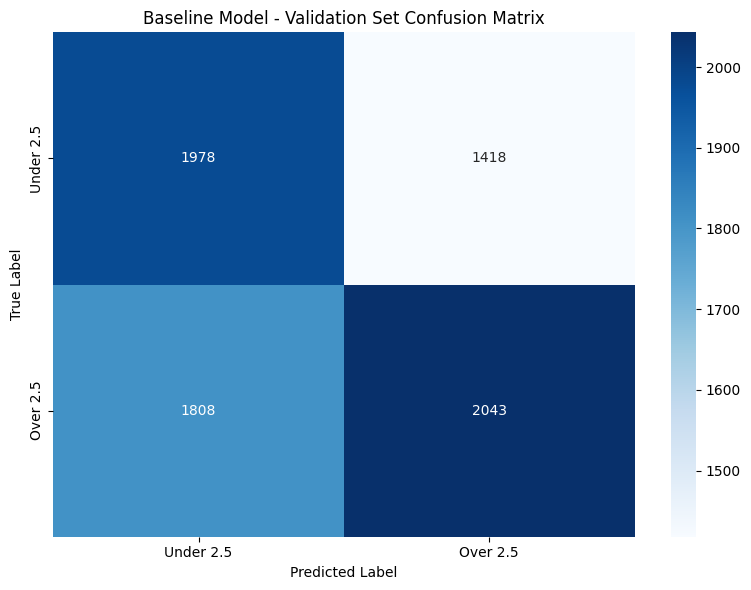

In [7]:
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """
    Plot confusion matrix as a heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Under 2.5', 'Over 2.5'],
                yticklabels=['Under 2.5', 'Over 2.5'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(baseline_val_results['confusion_matrix'], 
                     "Baseline Model - Validation Set Confusion Matrix")

## #2: Hyperparameter Tuning

### #2.1: Bayesian Optimization with Optuna
Use Optuna to perform Bayesian optimization to find optimal hyperparameters.

In [8]:
def objective(trial):
    """
    Objective function for Optuna hyperparameter optimization.
    Uses validation set to evaluate performance.
    Returns: Log Loss to minimize (penalizes confident incorrect predictions)
    """
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Create model with suggested hyperparameters
    model = RandomForestClassifier(**params)
    
    # Train on training set and evaluate on validation set
    model.fit(X_train, y_train)
    y_val_pred_proba = model.predict_proba(X_val)
    val_logloss = log_loss(y_val, y_val_pred_proba)
    
    return val_logloss

# Create study and optimize
print("Starting Bayesian Optimization with Optuna...")
print("Using validation set for hyperparameter evaluation...")
print("Optimizing Log Loss (lower is better, penalizes confident incorrect predictions)...")
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    study_name='random_forest_optuna'
)

# Record start time
start_time = time.time()

study.optimize(objective, n_trials=150, show_progress_bar=True)

# Calculate optimization time
optimization_time = time.time() - start_time

print(f"\nOptimization completed in {optimization_time:.1f} seconds")
print(f"Best Validation Log Loss: {study.best_value:.6f}")
print(f"Best trial: #{study.best_trial.number}")
print(f"\nBest hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

[I 2025-11-16 17:36:54,969] A new study created in memory with name: random_forest_optuna


Starting Bayesian Optimization with Optuna...
Using validation set for hyperparameter evaluation...
Optimizing Log Loss (lower is better, penalizes confident incorrect predictions)...


Best trial: 0. Best value: 0.688618:   1%|          | 1/150 [00:05<14:46,  5.95s/it]

[I 2025-11-16 17:37:00,923] Trial 0 finished with value: 0.6886176399675791 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6886176399675791.


Best trial: 1. Best value: 0.683759:   1%|▏         | 2/150 [00:09<11:00,  4.46s/it]

[I 2025-11-16 17:37:04,338] Trial 1 finished with value: 0.6837591723805483 and parameters: {'n_estimators': 383, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.6837591723805483.


Best trial: 1. Best value: 0.683759:   2%|▏         | 3/150 [01:20<1:25:59, 35.10s/it]

[I 2025-11-16 17:38:15,903] Trial 2 finished with value: 0.6848692400641089 and parameters: {'n_estimators': 273, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.6837591723805483.


Best trial: 1. Best value: 0.683759:   3%|▎         | 4/150 [03:18<2:44:09, 67.46s/it]

[I 2025-11-16 17:40:12,981] Trial 3 finished with value: 0.688844299406283 and parameters: {'n_estimators': 306, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.6837591723805483.


Best trial: 4. Best value: 0.682773:   3%|▎         | 5/150 [03:19<1:45:15, 43.55s/it]

[I 2025-11-16 17:40:14,135] Trial 4 finished with value: 0.6827729942950429 and parameters: {'n_estimators': 222, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 4 with value: 0.6827729942950429.


Best trial: 4. Best value: 0.682773:   4%|▍         | 6/150 [03:22<1:11:30, 29.80s/it]

[I 2025-11-16 17:40:17,228] Trial 5 finished with value: 0.6840688060702579 and parameters: {'n_estimators': 365, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 4 with value: 0.6827729942950429.


Best trial: 4. Best value: 0.682773:   5%|▍         | 7/150 [07:37<4:07:02, 103.66s/it]

[I 2025-11-16 17:44:32,947] Trial 6 finished with value: 1.6609728542902575 and parameters: {'n_estimators': 339, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 4 with value: 0.6827729942950429.


Best trial: 4. Best value: 0.682773:   5%|▌         | 8/150 [09:30<4:12:02, 106.50s/it]

[I 2025-11-16 17:46:25,531] Trial 7 finished with value: 0.6852597133990903 and parameters: {'n_estimators': 243, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 4 with value: 0.6827729942950429.


Best trial: 4. Best value: 0.682773:   6%|▌         | 9/150 [09:36<2:56:27, 75.09s/it] 

[I 2025-11-16 17:46:31,548] Trial 8 finished with value: 0.6954721728570685 and parameters: {'n_estimators': 102, 'max_depth': 26, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 4 with value: 0.6827729942950429.


Best trial: 4. Best value: 0.682773:   7%|▋         | 10/150 [09:41<2:04:42, 53.45s/it]

[I 2025-11-16 17:46:36,547] Trial 9 finished with value: 0.6844253180053324 and parameters: {'n_estimators': 349, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 4 with value: 0.6827729942950429.


Best trial: 4. Best value: 0.682773:   7%|▋         | 11/150 [09:45<1:28:25, 38.17s/it]

[I 2025-11-16 17:46:40,072] Trial 10 finished with value: 0.6841240123939704 and parameters: {'n_estimators': 478, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 4 with value: 0.6827729942950429.


Best trial: 4. Best value: 0.682773:   8%|▊         | 12/150 [09:47<1:03:03, 27.42s/it]

[I 2025-11-16 17:46:42,899] Trial 11 finished with value: 0.6839309650225398 and parameters: {'n_estimators': 159, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 4 with value: 0.6827729942950429.


Best trial: 12. Best value: 0.682659:   9%|▊         | 13/150 [09:53<47:13, 20.68s/it]  

[I 2025-11-16 17:46:48,076] Trial 12 finished with value: 0.6826588890716165 and parameters: {'n_estimators': 437, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 12 with value: 0.6826588890716165.


Best trial: 12. Best value: 0.682659:   9%|▉         | 14/150 [10:00<37:36, 16.59s/it]

[I 2025-11-16 17:46:55,219] Trial 13 finished with value: 0.6828230650137992 and parameters: {'n_estimators': 475, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 12 with value: 0.6826588890716165.


Best trial: 12. Best value: 0.682659:  10%|█         | 15/150 [10:03<28:13, 12.54s/it]

[I 2025-11-16 17:46:58,373] Trial 14 finished with value: 0.6851780245769067 and parameters: {'n_estimators': 191, 'max_depth': 18, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': True}. Best is trial 12 with value: 0.6826588890716165.


Best trial: 15. Best value: 0.682607:  11%|█         | 16/150 [10:09<23:33, 10.55s/it]

[I 2025-11-16 17:47:04,289] Trial 15 finished with value: 0.6826066896307343 and parameters: {'n_estimators': 422, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 15 with value: 0.6826066896307343.


Best trial: 16. Best value: 0.682601:  11%|█▏        | 17/150 [10:15<20:26,  9.22s/it]

[I 2025-11-16 17:47:10,432] Trial 16 finished with value: 0.6826012524880953 and parameters: {'n_estimators': 448, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 16 with value: 0.6826012524880953.


Best trial: 16. Best value: 0.682601:  12%|█▏        | 18/150 [10:26<21:44,  9.89s/it]

[I 2025-11-16 17:47:21,862] Trial 17 finished with value: 0.6901353439592056 and parameters: {'n_estimators': 418, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 16 with value: 0.6826012524880953.


Best trial: 16. Best value: 0.682601:  13%|█▎        | 19/150 [10:36<21:33,  9.88s/it]

[I 2025-11-16 17:47:31,718] Trial 18 finished with value: 0.6880656530332625 and parameters: {'n_estimators': 439, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 16 with value: 0.6826012524880953.


Best trial: 16. Best value: 0.682601:  13%|█▎        | 20/150 [10:44<19:49,  9.15s/it]

[I 2025-11-16 17:47:39,184] Trial 19 finished with value: 0.6830865672496108 and parameters: {'n_estimators': 491, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 16 with value: 0.6826012524880953.


Best trial: 16. Best value: 0.682601:  14%|█▍        | 21/150 [10:53<20:00,  9.30s/it]

[I 2025-11-16 17:47:48,840] Trial 20 finished with value: 0.6873265365409854 and parameters: {'n_estimators': 394, 'max_depth': 16, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 16 with value: 0.6826012524880953.


Best trial: 21. Best value: 0.68227:  15%|█▍        | 22/150 [11:00<17:59,  8.43s/it] 

[I 2025-11-16 17:47:55,242] Trial 21 finished with value: 0.6822704186317807 and parameters: {'n_estimators': 439, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  15%|█▌        | 23/150 [11:06<16:44,  7.91s/it]

[I 2025-11-16 17:48:01,942] Trial 22 finished with value: 0.6826571087860659 and parameters: {'n_estimators': 450, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  16%|█▌        | 24/150 [11:15<17:16,  8.22s/it]

[I 2025-11-16 17:48:10,886] Trial 23 finished with value: 0.6879326940004934 and parameters: {'n_estimators': 416, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  17%|█▋        | 25/150 [11:20<14:34,  6.99s/it]

[I 2025-11-16 17:48:15,009] Trial 24 finished with value: 0.6825382443371226 and parameters: {'n_estimators': 306, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  17%|█▋        | 26/150 [11:23<12:04,  5.84s/it]

[I 2025-11-16 17:48:18,159] Trial 25 finished with value: 0.6828422596262391 and parameters: {'n_estimators': 306, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  18%|█▊        | 27/150 [11:28<11:54,  5.81s/it]

[I 2025-11-16 17:48:23,897] Trial 26 finished with value: 0.6839335033416366 and parameters: {'n_estimators': 339, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  19%|█▊        | 28/150 [11:38<14:23,  7.08s/it]

[I 2025-11-16 17:48:33,938] Trial 27 finished with value: 0.6871468382615689 and parameters: {'n_estimators': 461, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  19%|█▉        | 29/150 [13:35<1:20:30, 39.92s/it]

[I 2025-11-16 17:50:30,488] Trial 28 finished with value: 0.7202596608807 and parameters: {'n_estimators': 394, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  20%|██        | 30/150 [13:45<1:01:42, 30.85s/it]

[I 2025-11-16 17:50:40,176] Trial 29 finished with value: 0.6957533887021174 and parameters: {'n_estimators': 286, 'max_depth': 23, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  21%|██        | 31/150 [14:00<51:59, 26.21s/it]  

[I 2025-11-16 17:50:55,569] Trial 30 finished with value: 0.6945452228543977 and parameters: {'n_estimators': 500, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  21%|██▏       | 32/150 [14:03<37:52, 19.26s/it]

[I 2025-11-16 17:50:58,607] Trial 31 finished with value: 0.6825846723013654 and parameters: {'n_estimators': 416, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  22%|██▏       | 33/150 [14:05<27:38, 14.17s/it]

[I 2025-11-16 17:51:00,906] Trial 32 finished with value: 0.6824942004559094 and parameters: {'n_estimators': 383, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  23%|██▎       | 34/150 [14:07<20:10, 10.43s/it]

[I 2025-11-16 17:51:02,617] Trial 33 finished with value: 0.6835300414343812 and parameters: {'n_estimators': 372, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  23%|██▎       | 35/150 [14:10<15:48,  8.24s/it]

[I 2025-11-16 17:51:05,755] Trial 34 finished with value: 0.6831298848904046 and parameters: {'n_estimators': 326, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  24%|██▍       | 36/150 [14:14<13:04,  6.88s/it]

[I 2025-11-16 17:51:09,463] Trial 35 finished with value: 0.682697951958425 and parameters: {'n_estimators': 399, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  25%|██▍       | 37/150 [16:28<1:24:35, 44.92s/it]

[I 2025-11-16 17:53:23,120] Trial 36 finished with value: 0.8983884340564776 and parameters: {'n_estimators': 263, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  25%|██▌       | 38/150 [16:30<59:56, 32.11s/it]  

[I 2025-11-16 17:53:25,360] Trial 37 finished with value: 0.6830895053272599 and parameters: {'n_estimators': 366, 'max_depth': 6, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  26%|██▌       | 39/150 [16:40<47:03, 25.44s/it]

[I 2025-11-16 17:53:35,233] Trial 38 finished with value: 0.6871614352465386 and parameters: {'n_estimators': 322, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  27%|██▋       | 40/150 [17:44<1:08:13, 37.22s/it]

[I 2025-11-16 17:54:39,929] Trial 39 finished with value: 0.6826493829854864 and parameters: {'n_estimators': 291, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  27%|██▋       | 41/150 [17:48<49:08, 27.05s/it]  

[I 2025-11-16 17:54:43,250] Trial 40 finished with value: 0.6839951365767092 and parameters: {'n_estimators': 235, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  28%|██▊       | 42/150 [17:52<36:37, 20.35s/it]

[I 2025-11-16 17:54:47,965] Trial 41 finished with value: 0.6825261201445187 and parameters: {'n_estimators': 463, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  29%|██▊       | 43/150 [17:58<28:12, 15.82s/it]

[I 2025-11-16 17:54:53,217] Trial 42 finished with value: 0.6831383098587989 and parameters: {'n_estimators': 465, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  29%|██▉       | 44/150 [18:01<21:03, 11.92s/it]

[I 2025-11-16 17:54:56,028] Trial 43 finished with value: 0.6835276701925466 and parameters: {'n_estimators': 407, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  30%|███       | 45/150 [18:03<15:53,  9.08s/it]

[I 2025-11-16 17:54:58,495] Trial 44 finished with value: 0.6840815543296489 and parameters: {'n_estimators': 428, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  31%|███       | 46/150 [18:05<12:17,  7.09s/it]

[I 2025-11-16 17:55:00,936] Trial 45 finished with value: 0.6829162153477929 and parameters: {'n_estimators': 379, 'max_depth': 7, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  31%|███▏      | 47/150 [18:15<13:19,  7.76s/it]

[I 2025-11-16 17:55:10,276] Trial 46 finished with value: 0.6884839762456977 and parameters: {'n_estimators': 474, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  32%|███▏      | 48/150 [19:24<44:16, 26.04s/it]

[I 2025-11-16 17:56:18,974] Trial 47 finished with value: 0.8009525162933744 and parameters: {'n_estimators': 193, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  33%|███▎      | 49/150 [19:34<35:58, 21.37s/it]

[I 2025-11-16 17:56:29,446] Trial 48 finished with value: 0.6868511986467623 and parameters: {'n_estimators': 355, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  33%|███▎      | 50/150 [19:39<27:34, 16.54s/it]

[I 2025-11-16 17:56:34,715] Trial 49 finished with value: 0.6841457201107412 and parameters: {'n_estimators': 456, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': True}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  34%|███▍      | 51/150 [19:43<21:04, 12.77s/it]

[I 2025-11-16 17:56:38,693] Trial 50 finished with value: 0.682564083341404 and parameters: {'n_estimators': 436, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  35%|███▍      | 52/150 [19:47<16:35, 10.15s/it]

[I 2025-11-16 17:56:42,739] Trial 51 finished with value: 0.6828912182921031 and parameters: {'n_estimators': 434, 'max_depth': 8, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  35%|███▌      | 53/150 [19:52<13:41,  8.47s/it]

[I 2025-11-16 17:56:47,277] Trial 52 finished with value: 0.6830131376228885 and parameters: {'n_estimators': 386, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  36%|███▌      | 54/150 [19:56<11:41,  7.30s/it]

[I 2025-11-16 17:56:51,857] Trial 53 finished with value: 0.6824719490600615 and parameters: {'n_estimators': 486, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  37%|███▋      | 55/150 [19:59<09:28,  5.99s/it]

[I 2025-11-16 17:56:54,769] Trial 54 finished with value: 0.6841181237236634 and parameters: {'n_estimators': 481, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  37%|███▋      | 56/150 [20:04<08:39,  5.53s/it]

[I 2025-11-16 17:56:59,237] Trial 55 finished with value: 0.682668037741458 and parameters: {'n_estimators': 486, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  38%|███▊      | 57/150 [20:07<07:37,  4.92s/it]

[I 2025-11-16 17:57:02,733] Trial 56 finished with value: 0.6830016567715812 and parameters: {'n_estimators': 446, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  39%|███▊      | 58/150 [20:11<06:48,  4.44s/it]

[I 2025-11-16 17:57:06,062] Trial 57 finished with value: 0.6835558389239755 and parameters: {'n_estimators': 498, 'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  39%|███▉      | 59/150 [20:22<09:41,  6.39s/it]

[I 2025-11-16 17:57:17,000] Trial 58 finished with value: 0.6970397508416928 and parameters: {'n_estimators': 465, 'max_depth': 26, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  40%|████      | 60/150 [20:27<09:10,  6.11s/it]

[I 2025-11-16 17:57:22,460] Trial 59 finished with value: 0.6838577146874733 and parameters: {'n_estimators': 430, 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  41%|████      | 61/150 [22:03<49:11, 33.17s/it]

[I 2025-11-16 17:58:58,759] Trial 60 finished with value: 0.6829920140057052 and parameters: {'n_estimators': 409, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': True}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  41%|████▏     | 62/150 [22:07<35:43, 24.35s/it]

[I 2025-11-16 17:59:02,543] Trial 61 finished with value: 0.6828654505219398 and parameters: {'n_estimators': 453, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  42%|████▏     | 63/150 [22:10<26:01, 17.95s/it]

[I 2025-11-16 17:59:05,565] Trial 62 finished with value: 0.6825448817633101 and parameters: {'n_estimators': 421, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  43%|████▎     | 64/150 [22:13<19:08, 13.36s/it]

[I 2025-11-16 17:59:08,201] Trial 63 finished with value: 0.6825763143056714 and parameters: {'n_estimators': 441, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  43%|████▎     | 65/150 [22:15<14:06,  9.96s/it]

[I 2025-11-16 17:59:10,228] Trial 64 finished with value: 0.6834919735934152 and parameters: {'n_estimators': 476, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 21. Best value: 0.68227:  44%|████▍     | 66/150 [22:15<09:59,  7.14s/it]

[I 2025-11-16 17:59:10,795] Trial 65 finished with value: 0.6830530971048177 and parameters: {'n_estimators': 104, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 21 with value: 0.6822704186317807.


Best trial: 66. Best value: 0.682267:  45%|████▍     | 67/150 [22:18<07:55,  5.73s/it]

[I 2025-11-16 17:59:13,244] Trial 66 finished with value: 0.6822674179780445 and parameters: {'n_estimators': 423, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'log2', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  45%|████▌     | 68/150 [22:22<07:13,  5.29s/it]

[I 2025-11-16 17:59:17,485] Trial 67 finished with value: 0.6825021840375955 and parameters: {'n_estimators': 344, 'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  46%|████▌     | 69/150 [22:27<07:08,  5.29s/it]

[I 2025-11-16 17:59:22,776] Trial 68 finished with value: 0.6862630141327135 and parameters: {'n_estimators': 318, 'max_depth': 13, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  47%|████▋     | 70/150 [22:35<07:56,  5.96s/it]

[I 2025-11-16 17:59:30,296] Trial 69 finished with value: 0.6909707775554002 and parameters: {'n_estimators': 334, 'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  47%|████▋     | 71/150 [22:40<07:24,  5.63s/it]

[I 2025-11-16 17:59:35,165] Trial 70 finished with value: 0.6825624876228189 and parameters: {'n_estimators': 342, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  48%|████▊     | 72/150 [22:45<07:22,  5.68s/it]

[I 2025-11-16 17:59:40,944] Trial 71 finished with value: 0.6835087571876491 and parameters: {'n_estimators': 353, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  49%|████▊     | 73/150 [22:52<07:38,  5.95s/it]

[I 2025-11-16 17:59:47,532] Trial 72 finished with value: 0.6824428401235713 and parameters: {'n_estimators': 309, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  49%|████▉     | 74/150 [23:00<08:24,  6.64s/it]

[I 2025-11-16 17:59:55,794] Trial 73 finished with value: 0.6841486557272669 and parameters: {'n_estimators': 305, 'max_depth': 11, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  50%|█████     | 75/150 [23:07<08:08,  6.51s/it]

[I 2025-11-16 18:00:02,008] Trial 74 finished with value: 0.6824134665523293 and parameters: {'n_estimators': 278, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  51%|█████     | 76/150 [23:15<08:39,  7.02s/it]

[I 2025-11-16 18:00:10,204] Trial 75 finished with value: 0.6852770921729867 and parameters: {'n_estimators': 273, 'max_depth': 12, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  51%|█████▏    | 77/150 [23:21<08:10,  6.72s/it]

[I 2025-11-16 18:00:16,231] Trial 76 finished with value: 0.6823119394655409 and parameters: {'n_estimators': 265, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  52%|█████▏    | 78/150 [23:27<07:51,  6.55s/it]

[I 2025-11-16 18:00:22,392] Trial 77 finished with value: 0.6832903736110604 and parameters: {'n_estimators': 248, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  53%|█████▎    | 79/150 [23:32<07:04,  5.98s/it]

[I 2025-11-16 18:00:27,021] Trial 78 finished with value: 0.68230189781051 and parameters: {'n_estimators': 265, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  53%|█████▎    | 80/150 [23:35<05:55,  5.07s/it]

[I 2025-11-16 18:00:29,986] Trial 79 finished with value: 0.6824192384729783 and parameters: {'n_estimators': 214, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  54%|█████▍    | 81/150 [23:37<05:06,  4.44s/it]

[I 2025-11-16 18:00:32,946] Trial 80 finished with value: 0.682460829169076 and parameters: {'n_estimators': 213, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  55%|█████▍    | 82/150 [23:40<04:29,  3.97s/it]

[I 2025-11-16 18:00:35,809] Trial 81 finished with value: 0.6824864949651009 and parameters: {'n_estimators': 207, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  55%|█████▌    | 83/150 [23:43<03:50,  3.44s/it]

[I 2025-11-16 18:00:38,011] Trial 82 finished with value: 0.6835488761095171 and parameters: {'n_estimators': 234, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  56%|█████▌    | 84/150 [23:46<03:48,  3.47s/it]

[I 2025-11-16 18:00:41,547] Trial 83 finished with value: 0.6824388033437081 and parameters: {'n_estimators': 261, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  57%|█████▋    | 85/150 [23:50<03:48,  3.52s/it]

[I 2025-11-16 18:00:45,191] Trial 84 finished with value: 0.6824388033437081 and parameters: {'n_estimators': 261, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  57%|█████▋    | 86/150 [23:53<03:39,  3.42s/it]

[I 2025-11-16 18:00:48,392] Trial 85 finished with value: 0.6830974367719815 and parameters: {'n_estimators': 265, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  58%|█████▊    | 87/150 [23:56<03:31,  3.35s/it]

[I 2025-11-16 18:00:51,582] Trial 86 finished with value: 0.6830175612607192 and parameters: {'n_estimators': 284, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  59%|█████▊    | 88/150 [23:58<02:56,  2.84s/it]

[I 2025-11-16 18:00:53,222] Trial 87 finished with value: 0.6835959912608967 and parameters: {'n_estimators': 158, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  59%|█████▉    | 89/150 [24:01<03:02,  2.99s/it]

[I 2025-11-16 18:00:56,573] Trial 88 finished with value: 0.6827288692010455 and parameters: {'n_estimators': 258, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  60%|██████    | 90/150 [24:06<03:36,  3.60s/it]

[I 2025-11-16 18:01:01,599] Trial 89 finished with value: 0.6826550185165258 and parameters: {'n_estimators': 274, 'max_depth': 10, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  61%|██████    | 91/150 [24:13<04:23,  4.47s/it]

[I 2025-11-16 18:01:08,097] Trial 90 finished with value: 0.6857813891109102 and parameters: {'n_estimators': 239, 'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  61%|██████▏   | 92/150 [24:16<03:53,  4.02s/it]

[I 2025-11-16 18:01:11,055] Trial 91 finished with value: 0.6824501214484904 and parameters: {'n_estimators': 222, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  62%|██████▏   | 93/150 [24:18<03:29,  3.68s/it]

[I 2025-11-16 18:01:13,950] Trial 92 finished with value: 0.6824762174373658 and parameters: {'n_estimators': 221, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  63%|██████▎   | 94/150 [24:23<03:48,  4.08s/it]

[I 2025-11-16 18:01:18,968] Trial 93 finished with value: 0.6824771751255706 and parameters: {'n_estimators': 293, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  63%|██████▎   | 95/150 [24:27<03:27,  3.78s/it]

[I 2025-11-16 18:01:22,036] Trial 94 finished with value: 0.6831169537766157 and parameters: {'n_estimators': 258, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  64%|██████▍   | 96/150 [24:30<03:13,  3.58s/it]

[I 2025-11-16 18:01:25,167] Trial 95 finished with value: 0.6827968159564983 and parameters: {'n_estimators': 176, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  65%|██████▍   | 97/150 [24:32<02:50,  3.22s/it]

[I 2025-11-16 18:01:27,529] Trial 96 finished with value: 0.6835179395895937 and parameters: {'n_estimators': 224, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  65%|██████▌   | 98/150 [24:36<03:01,  3.48s/it]

[I 2025-11-16 18:01:31,636] Trial 97 finished with value: 0.6824398817529815 and parameters: {'n_estimators': 273, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  66%|██████▌   | 99/150 [24:42<03:36,  4.24s/it]

[I 2025-11-16 18:01:37,641] Trial 98 finished with value: 0.6832410921644886 and parameters: {'n_estimators': 278, 'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  67%|██████▋   | 100/150 [24:48<03:53,  4.66s/it]

[I 2025-11-16 18:01:43,288] Trial 99 finished with value: 0.6824888715253563 and parameters: {'n_estimators': 314, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  67%|██████▋   | 101/150 [24:57<05:00,  6.12s/it]

[I 2025-11-16 18:01:52,823] Trial 100 finished with value: 0.6865890867016115 and parameters: {'n_estimators': 296, 'max_depth': 24, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  68%|██████▊   | 102/150 [25:01<04:17,  5.36s/it]

[I 2025-11-16 18:01:56,389] Trial 101 finished with value: 0.6825052019427095 and parameters: {'n_estimators': 247, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  69%|██████▊   | 103/150 [25:05<04:00,  5.11s/it]

[I 2025-11-16 18:02:00,924] Trial 102 finished with value: 0.6831467074962921 and parameters: {'n_estimators': 255, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  69%|██████▉   | 104/150 [25:09<03:34,  4.66s/it]

[I 2025-11-16 18:02:04,522] Trial 103 finished with value: 0.6824930955146181 and parameters: {'n_estimators': 229, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  70%|███████   | 105/150 [25:14<03:27,  4.62s/it]

[I 2025-11-16 18:02:09,055] Trial 104 finished with value: 0.6825135799594014 and parameters: {'n_estimators': 282, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  71%|███████   | 106/150 [25:17<03:09,  4.31s/it]

[I 2025-11-16 18:02:12,632] Trial 105 finished with value: 0.6828698993596762 and parameters: {'n_estimators': 267, 'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  71%|███████▏  | 107/150 [26:01<11:30, 16.05s/it]

[I 2025-11-16 18:02:56,092] Trial 106 finished with value: 0.6827332945815846 and parameters: {'n_estimators': 201, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  72%|███████▏  | 108/150 [26:05<08:47, 12.56s/it]

[I 2025-11-16 18:03:00,514] Trial 107 finished with value: 0.6828876338599832 and parameters: {'n_estimators': 243, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  73%|███████▎  | 109/150 [26:10<06:55, 10.14s/it]

[I 2025-11-16 18:03:04,992] Trial 108 finished with value: 0.6825491853465416 and parameters: {'n_estimators': 270, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  73%|███████▎  | 110/150 [26:12<05:15,  7.89s/it]

[I 2025-11-16 18:03:07,639] Trial 109 finished with value: 0.6829524973920551 and parameters: {'n_estimators': 184, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  74%|███████▍  | 111/150 [26:17<04:36,  7.09s/it]

[I 2025-11-16 18:03:12,874] Trial 110 finished with value: 0.68482268094073 and parameters: {'n_estimators': 252, 'max_depth': 12, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  75%|███████▍  | 112/150 [26:20<03:38,  5.76s/it]

[I 2025-11-16 18:03:15,520] Trial 111 finished with value: 0.6824383209487653 and parameters: {'n_estimators': 211, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  75%|███████▌  | 113/150 [26:23<03:03,  4.96s/it]

[I 2025-11-16 18:03:18,629] Trial 112 finished with value: 0.6825275925987383 and parameters: {'n_estimators': 217, 'max_depth': 8, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  76%|███████▌  | 114/150 [26:27<02:44,  4.58s/it]

[I 2025-11-16 18:03:22,309] Trial 113 finished with value: 0.6825158901516751 and parameters: {'n_estimators': 287, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  77%|███████▋  | 115/150 [26:31<02:31,  4.32s/it]

[I 2025-11-16 18:03:26,027] Trial 114 finished with value: 0.6830579815251587 and parameters: {'n_estimators': 232, 'max_depth': 9, 'min_samples_split': 19, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  77%|███████▋  | 116/150 [26:34<02:16,  4.02s/it]

[I 2025-11-16 18:03:29,336] Trial 115 finished with value: 0.6823369886606463 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  78%|███████▊  | 117/150 [26:38<02:13,  4.03s/it]

[I 2025-11-16 18:03:33,400] Trial 116 finished with value: 0.683626822085897 and parameters: {'n_estimators': 166, 'max_depth': 10, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  79%|███████▊  | 118/150 [26:42<02:09,  4.05s/it]

[I 2025-11-16 18:03:37,509] Trial 117 finished with value: 0.6846213096309438 and parameters: {'n_estimators': 148, 'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  79%|███████▉  | 119/150 [27:19<07:08, 13.83s/it]

[I 2025-11-16 18:04:14,155] Trial 118 finished with value: 0.6983035887737463 and parameters: {'n_estimators': 203, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 66. Best value: 0.682267:  80%|████████  | 120/150 [27:23<05:25, 10.84s/it]

[I 2025-11-16 18:04:18,028] Trial 119 finished with value: 0.6828180886815906 and parameters: {'n_estimators': 189, 'max_depth': 8, 'min_samples_split': 19, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 66 with value: 0.6822674179780445.


Best trial: 120. Best value: 0.682176:  81%|████████  | 121/150 [27:27<04:19,  8.94s/it]

[I 2025-11-16 18:04:22,534] Trial 120 finished with value: 0.6821762890106652 and parameters: {'n_estimators': 262, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 120 with value: 0.6821762890106652.


Best trial: 120. Best value: 0.682176:  81%|████████▏ | 122/150 [27:32<03:34,  7.65s/it]

[I 2025-11-16 18:04:27,181] Trial 121 finished with value: 0.6821967029068069 and parameters: {'n_estimators': 258, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 120 with value: 0.6821762890106652.


Best trial: 120. Best value: 0.682176:  82%|████████▏ | 123/150 [27:36<02:57,  6.56s/it]

[I 2025-11-16 18:04:31,185] Trial 122 finished with value: 0.6827724966957971 and parameters: {'n_estimators': 262, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 120 with value: 0.6821762890106652.


Best trial: 120. Best value: 0.682176:  83%|████████▎ | 124/150 [27:40<02:32,  5.87s/it]

[I 2025-11-16 18:04:35,439] Trial 123 finished with value: 0.6823207035595232 and parameters: {'n_estimators': 243, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 120 with value: 0.6821762890106652.


Best trial: 120. Best value: 0.682176:  83%|████████▎ | 125/150 [27:44<02:14,  5.37s/it]

[I 2025-11-16 18:04:39,635] Trial 124 finished with value: 0.6822604554763408 and parameters: {'n_estimators': 241, 'max_depth': 7, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 120 with value: 0.6821762890106652.


Best trial: 120. Best value: 0.682176:  84%|████████▍ | 126/150 [27:48<01:55,  4.81s/it]

[I 2025-11-16 18:04:43,133] Trial 125 finished with value: 0.6828356666671351 and parameters: {'n_estimators': 246, 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 120 with value: 0.6821762890106652.


Best trial: 120. Best value: 0.682176:  85%|████████▍ | 127/150 [27:50<01:36,  4.21s/it]

[I 2025-11-16 18:04:45,961] Trial 126 finished with value: 0.6837327729037527 and parameters: {'n_estimators': 214, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 120 with value: 0.6821762890106652.


Best trial: 120. Best value: 0.682176:  85%|████████▌ | 128/150 [27:55<01:32,  4.21s/it]

[I 2025-11-16 18:04:50,166] Trial 127 finished with value: 0.6822790599990071 and parameters: {'n_estimators': 241, 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 120 with value: 0.6821762890106652.


Best trial: 120. Best value: 0.682176:  86%|████████▌ | 129/150 [27:58<01:24,  4.03s/it]

[I 2025-11-16 18:04:53,757] Trial 128 finished with value: 0.6828488188070162 and parameters: {'n_estimators': 240, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 120 with value: 0.6821762890106652.


Best trial: 129. Best value: 0.682082:  87%|████████▋ | 130/150 [28:02<01:19,  3.96s/it]

[I 2025-11-16 18:04:57,572] Trial 129 finished with value: 0.682081700194391 and parameters: {'n_estimators': 210, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 129 with value: 0.682081700194391.


Best trial: 129. Best value: 0.682082:  87%|████████▋ | 131/150 [28:07<01:18,  4.16s/it]

[I 2025-11-16 18:05:02,180] Trial 130 finished with value: 0.6823410781496208 and parameters: {'n_estimators': 232, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 129 with value: 0.682081700194391.


Best trial: 129. Best value: 0.682082:  88%|████████▊ | 132/150 [28:11<01:17,  4.32s/it]

[I 2025-11-16 18:05:06,887] Trial 131 finished with value: 0.6822685430606173 and parameters: {'n_estimators': 227, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 129 with value: 0.682081700194391.


Best trial: 129. Best value: 0.682082:  89%|████████▊ | 133/150 [28:15<01:11,  4.22s/it]

[I 2025-11-16 18:05:10,869] Trial 132 finished with value: 0.6823277585599766 and parameters: {'n_estimators': 196, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 129 with value: 0.682081700194391.


Best trial: 129. Best value: 0.682082:  89%|████████▉ | 134/150 [28:20<01:08,  4.29s/it]

[I 2025-11-16 18:05:15,326] Trial 133 finished with value: 0.6822685430606171 and parameters: {'n_estimators': 227, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 129 with value: 0.682081700194391.


Best trial: 129. Best value: 0.682082:  90%|█████████ | 135/150 [28:24<01:03,  4.20s/it]

[I 2025-11-16 18:05:19,324] Trial 134 finished with value: 0.6823643880627903 and parameters: {'n_estimators': 199, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 129 with value: 0.682081700194391.


Best trial: 129. Best value: 0.682082:  91%|█████████ | 136/150 [28:29<01:01,  4.38s/it]

[I 2025-11-16 18:05:24,125] Trial 135 finished with value: 0.6823979034313271 and parameters: {'n_estimators': 240, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 129 with value: 0.682081700194391.


Best trial: 136. Best value: 0.682077:  91%|█████████▏| 137/150 [28:33<00:55,  4.26s/it]

[I 2025-11-16 18:05:28,112] Trial 136 finished with value: 0.6820766948221834 and parameters: {'n_estimators': 228, 'max_depth': 7, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 136 with value: 0.6820766948221834.


Best trial: 136. Best value: 0.682077:  92%|█████████▏| 138/150 [28:36<00:48,  4.05s/it]

[I 2025-11-16 18:05:31,671] Trial 137 finished with value: 0.682825912975398 and parameters: {'n_estimators': 251, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 136 with value: 0.6820766948221834.


Best trial: 136. Best value: 0.682077:  93%|█████████▎| 139/150 [29:47<04:24, 24.02s/it]

[I 2025-11-16 18:06:42,270] Trial 138 finished with value: 0.7674954283361818 and parameters: {'n_estimators': 229, 'max_depth': 8, 'min_samples_split': 16, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False}. Best is trial 136 with value: 0.6820766948221834.


Best trial: 139. Best value: 0.682047:  93%|█████████▎| 140/150 [29:51<02:59, 17.94s/it]

[I 2025-11-16 18:06:46,018] Trial 139 finished with value: 0.6820467243426044 and parameters: {'n_estimators': 222, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 139 with value: 0.6820467243426044.


Best trial: 139. Best value: 0.682047:  94%|█████████▍| 141/150 [29:54<02:02, 13.59s/it]

[I 2025-11-16 18:06:49,451] Trial 140 finished with value: 0.6827781083181318 and parameters: {'n_estimators': 222, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 139 with value: 0.6820467243426044.


Best trial: 139. Best value: 0.682047:  95%|█████████▍| 142/150 [29:58<01:25, 10.68s/it]

[I 2025-11-16 18:06:53,356] Trial 141 finished with value: 0.6824661815934003 and parameters: {'n_estimators': 237, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 139 with value: 0.6820467243426044.


Best trial: 139. Best value: 0.682047:  95%|█████████▌| 143/150 [30:01<00:58,  8.32s/it]

[I 2025-11-16 18:06:56,153] Trial 142 finished with value: 0.6825553510443261 and parameters: {'n_estimators': 228, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 139 with value: 0.6820467243426044.


Best trial: 139. Best value: 0.682047:  96%|█████████▌| 144/150 [30:06<00:43,  7.32s/it]

[I 2025-11-16 18:07:01,163] Trial 143 finished with value: 0.6823686525676737 and parameters: {'n_estimators': 252, 'max_depth': 8, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 139 with value: 0.6820467243426044.


Best trial: 139. Best value: 0.682047:  97%|█████████▋| 145/150 [30:10<00:31,  6.31s/it]

[I 2025-11-16 18:07:05,096] Trial 144 finished with value: 0.6826083703936306 and parameters: {'n_estimators': 192, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 139 with value: 0.6820467243426044.


Best trial: 139. Best value: 0.682047:  97%|█████████▋| 146/150 [30:19<00:28,  7.12s/it]

[I 2025-11-16 18:07:14,120] Trial 145 finished with value: 0.6934157149129255 and parameters: {'n_estimators': 207, 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 139 with value: 0.6820467243426044.


Best trial: 139. Best value: 0.682047:  98%|█████████▊| 147/150 [30:23<00:18,  6.21s/it]

[I 2025-11-16 18:07:18,202] Trial 146 finished with value: 0.6821565791450361 and parameters: {'n_estimators': 245, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 139 with value: 0.6820467243426044.


Best trial: 139. Best value: 0.682047:  99%|█████████▊| 148/150 [30:26<00:10,  5.42s/it]

[I 2025-11-16 18:07:21,792] Trial 147 finished with value: 0.6837841764668219 and parameters: {'n_estimators': 222, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 139 with value: 0.6820467243426044.


Best trial: 139. Best value: 0.682047:  99%|█████████▉| 149/150 [30:29<00:04,  4.67s/it]

[I 2025-11-16 18:07:24,697] Trial 148 finished with value: 0.6827360286916612 and parameters: {'n_estimators': 247, 'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 139 with value: 0.6820467243426044.


Best trial: 149. Best value: 0.682023: 100%|██████████| 150/150 [30:34<00:00, 12.23s/it]

[I 2025-11-16 18:07:29,454] Trial 149 finished with value: 0.68202326016167 and parameters: {'n_estimators': 235, 'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 149 with value: 0.68202326016167.

Optimization completed in 1834.5 seconds
Best Validation Log Loss: 0.682023
Best trial: #149

Best hyperparameters:
  n_estimators: 235
  max_depth: 7
  min_samples_split: 16
  min_samples_leaf: 5
  max_features: sqrt
  bootstrap: False


### #2.2: Manual Bayesian Optimization with Gaussian Processes
Implement Bayesian optimization from scratch using Gaussian Processes as surrogate model and UCB acquisition function.

In [9]:
# --------------------------------------------
#  Define objective function for manual BO
# --------------------------------------------
def evaluate_rf_manual(params):
    """
    Evaluate Random Forest with given hyperparameters using validation set.
    Returns: Log Loss to minimize (penalizes confident incorrect predictions)
    """
    # Handle max_features categorical parameter (encoded as continuous for GP)
    max_features_map = {0: 'sqrt', 1: 'log2', 2: None}
    max_features_idx = int(round(params[4]))
    max_features_idx = np.clip(max_features_idx, 0, 2)  # Ensure valid range
    max_features_val = max_features_map[max_features_idx]
    
    # Handle bootstrap boolean (encoded as continuous for GP)
    bootstrap_val = bool(params[5] > 0.5)
    
    model = RandomForestClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        min_samples_split=int(params[2]),
        min_samples_leaf=int(params[3]),
        max_features=max_features_val,
        bootstrap=bootstrap_val,
        random_state=42,
        n_jobs=-1
    )
    
    # Train on training set and evaluate on validation set
    model.fit(X_train, y_train)
    y_val_pred_proba = model.predict_proba(X_val)
    val_logloss = log_loss(y_val, y_val_pred_proba)
    
    # Return log loss (already a minimization metric)
    return val_logloss

# --------------------------------------------
#  Define search space bounds
# --------------------------------------------
param_bounds = np.array([
    [100, 500],      # n_estimators: 100-500
    [5, 30],         # max_depth: 5-30
    [2, 20],         # min_samples_split: 2-20
    [1, 10],         # min_samples_leaf: 1-10
    [0, 2],          # max_features: 0='sqrt', 1='log2', 2=None
    [0, 1],          # bootstrap: 0=False, 1=True (continuous for GP)
])

n_params = param_bounds.shape[0]

# --------------------------------------------
#  Initialize samples (random warm-up phase)
# --------------------------------------------
np.random.seed(42)
N_INIT = 20  # Initial random samples to warm up the GP

print("🔧 Initializing Manual Bayesian Optimization...")
print(f"Generating {N_INIT} random initial samples...")

X_samples = np.random.uniform(param_bounds[:, 0], param_bounds[:, 1], size=(N_INIT, n_params))
Y_samples = np.array([evaluate_rf_manual(x) for x in X_samples])

print(f"Initial samples generated. Best initial Validation Log Loss: {np.min(Y_samples):.6f}")

# --------------------------------------------
#  Fit Gaussian Process surrogate model
# --------------------------------------------
kernel = Matern(length_scale=1.0, nu=2.5)
gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=3,
    random_state=42
)

# Normalize features for better GP performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_samples)
gp.fit(X_scaled, Y_samples)

# --------------------------------------------
#  Acquisition function (Upper Confidence Bound)
# --------------------------------------------
def acquisition_ucb(X, model, kappa=2.0):
    """
    Upper Confidence Bound acquisition function.
    Since we're minimizing Log Loss, we use LCB (Lower Confidence Bound).
    
    LCB = mu - kappa * sigma (for minimization)
    """
    mu, sigma = model.predict(X, return_std=True)
    return mu - kappa * sigma  # Lower is better for minimization

def propose_next(model, bounds, scaler, n_candidates=2000):
    """Propose next point to evaluate using acquisition function"""
    candidates = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_candidates, bounds.shape[0]))
    candidates_scaled = scaler.transform(candidates)
    acq_vals = acquisition_ucb(candidates_scaled, model)
    best_idx = np.argmin(acq_vals)
    return candidates[best_idx].reshape(1, -1)

# --------------------------------------------
#  Bayesian Optimization loop
# --------------------------------------------
N_ITER = 130  # Number of BO iterations (150 total evaluations = 20 init + 130 iterations)
history_best = [np.min(Y_samples)]

print(f"\nStarting Bayesian Optimization loop with {N_ITER} iterations...")
start_time = time.time()

for i in range(N_ITER):
    # Propose next point using acquisition function
    x_next = propose_next(gp, param_bounds, scaler)
    y_next = evaluate_rf_manual(x_next[0])
    
    # Update dataset
    X_samples = np.vstack([X_samples, x_next])
    Y_samples = np.hstack([Y_samples, y_next])
    
    # Refit Gaussian Process
    X_scaled = scaler.fit_transform(X_samples)
    gp.fit(X_scaled, Y_samples)
    
    # Track progress
    history_best.append(np.min(Y_samples))
    current_best_logloss = np.min(Y_samples)
    current_logloss = y_next
    
    # Print every iteration to see progress
    if (i + 1) % 5 == 0 or i < 5:
        print(f"Iteration {i+1:02d}/{N_ITER}: Current Val Log Loss = {current_logloss:.6f}, Best Val Log Loss = {current_best_logloss:.6f}")

optimization_time = time.time() - start_time

# --------------------------------------------
#  Extract best parameters
# --------------------------------------------
best_idx = np.argmin(Y_samples)
best_params_array = X_samples[best_idx]
best_logloss_manual = Y_samples[best_idx]

# Convert to dictionary format
max_features_map = {0: 'sqrt', 1: 'log2', 2: None}
manual_bo_params = {
    'n_estimators': int(best_params_array[0]),
    'max_depth': int(best_params_array[1]),
    'min_samples_split': int(best_params_array[2]),
    'min_samples_leaf': int(best_params_array[3]),
    'max_features': max_features_map[int(round(np.clip(best_params_array[4], 0, 2)))],
    'bootstrap': bool(best_params_array[5] > 0.5),
}

print(f"\nManual Bayesian Optimization completed in {optimization_time:.1f} seconds")
print(f"Best Validation Log Loss: {best_logloss_manual:.6f}")
print(f"Total evaluations: {len(Y_samples)}")
print(f"\nBest hyperparameters found:")
for name, val in manual_bo_params.items():
    print(f"  {name}: {val}")

🔧 Initializing Manual Bayesian Optimization...
Generating 20 random initial samples...
Initial samples generated. Best initial Validation Log Loss: 0.682278

Starting Bayesian Optimization loop with 130 iterations...
Iteration 01/130: Current Val Log Loss = 0.685526, Best Val Log Loss = 0.682278
Iteration 02/130: Current Val Log Loss = 0.682896, Best Val Log Loss = 0.682278
Iteration 03/130: Current Val Log Loss = 0.687341, Best Val Log Loss = 0.682278
Iteration 04/130: Current Val Log Loss = 0.688933, Best Val Log Loss = 0.682278
Iteration 05/130: Current Val Log Loss = 0.698343, Best Val Log Loss = 0.682278
Iteration 10/130: Current Val Log Loss = 0.695099, Best Val Log Loss = 0.682278
Iteration 15/130: Current Val Log Loss = 0.684119, Best Val Log Loss = 0.682278
Iteration 20/130: Current Val Log Loss = 0.682915, Best Val Log Loss = 0.682278
Iteration 25/130: Current Val Log Loss = 0.689287, Best Val Log Loss = 0.682278
Iteration 30/130: Current Val Log Loss = 0.683756, Best Val Log

### #2.3: Compare Optimization Methods
Compare the performance of Optuna vs Manual Bayesian Optimization.


HYPERPARAMETER OPTIMIZATION COMPARISON

🔹 Optuna Optimization:
   Best Validation Log Loss: 0.682023
   Total evaluations: 150

🔹 Manual Bayesian Optimization:
   Best Validation Log Loss: 0.682132
   Total evaluations: 150

🔹 Difference:
   Optuna is better by 0.000108 (lower is better)


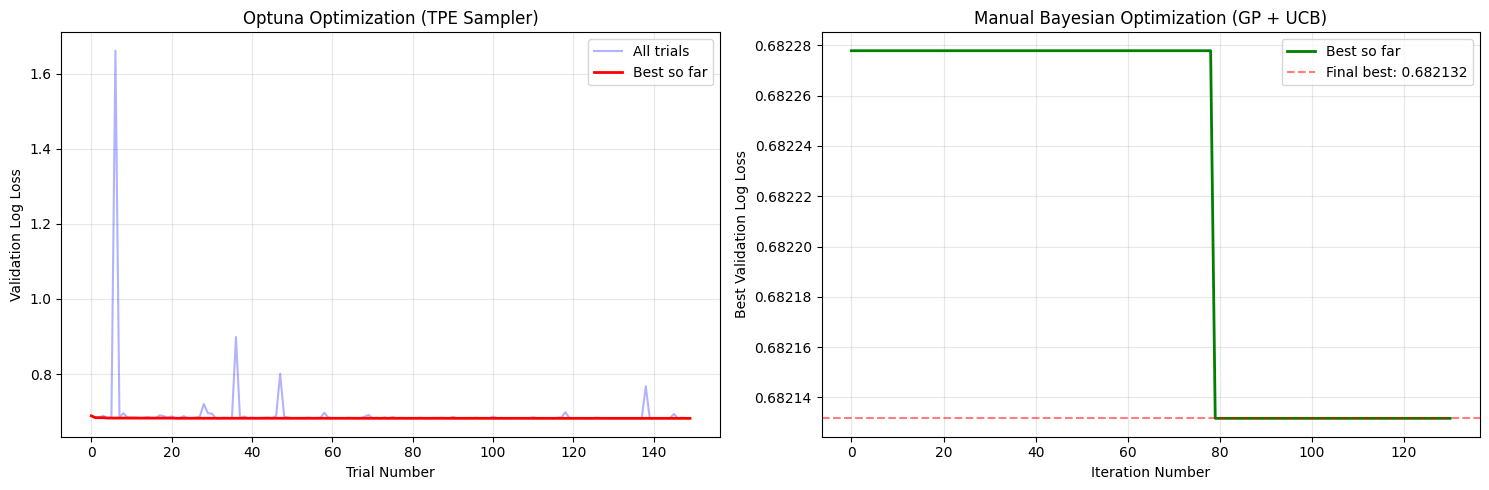


📊 Best Hyperparameters Comparison:
Parameter            Optuna               Manual BO           
------------------------------------------------------------
n_estimators         235                  112                 
max_depth            7                    8                   
min_samples_split    16                   5                   
min_samples_leaf     5                    4                   
max_features         sqrt                 sqrt                
bootstrap            False                True                


In [10]:
# Compare Optuna and Manual BO results
print("\n" + "="*70)
print("HYPERPARAMETER OPTIMIZATION COMPARISON")
print("="*70)

print(f"\n🔹 Optuna Optimization:")
print(f"   Best Validation Log Loss: {study.best_value:.6f}")
print(f"   Total evaluations: {len(study.trials)}")

print(f"\n🔹 Manual Bayesian Optimization:")
print(f"   Best Validation Log Loss: {best_logloss_manual:.6f}")
print(f"   Total evaluations: {len(Y_samples)}")

print(f"\n🔹 Difference:")
diff = study.best_value - best_logloss_manual
if diff < 0:
    print(f"   Optuna is better by {abs(diff):.6f} (lower is better)")
else:
    print(f"   Manual BO is better by {diff:.6f} (lower is better)")
print("="*70)

# Visualize optimization convergence
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Optuna optimization history
trials_df = study.trials_dataframe()
axes[0].plot(trials_df['number'], trials_df['value'], 'b-', alpha=0.3, label='All trials')
axes[0].plot(trials_df['number'], trials_df['value'].cummin(), 'r-', linewidth=2, label='Best so far')
axes[0].set_xlabel('Trial Number')
axes[0].set_ylabel('Validation Log Loss')
axes[0].set_title('Optuna Optimization (TPE Sampler)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Manual BO convergence
manual_best_curve = history_best  # Already in Log Loss (no conversion needed)
axes[1].plot(range(len(manual_best_curve)), manual_best_curve, 'g-', linewidth=2, label='Best so far')
axes[1].axhline(y=manual_best_curve[-1], color='r', linestyle='--', alpha=0.5, label=f'Final best: {manual_best_curve[-1]:.6f}')
axes[1].set_xlabel('Iteration Number')
axes[1].set_ylabel('Best Validation Log Loss')
axes[1].set_title('Manual Bayesian Optimization (GP + UCB)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare parameter distributions
print("\n📊 Best Hyperparameters Comparison:")
print(f"{'Parameter':<20} {'Optuna':<20} {'Manual BO':<20}")
print("-" * 60)
for param in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'bootstrap']:
    optuna_val = study.best_params.get(param, 'N/A')
    manual_val = manual_bo_params.get(param, 'N/A')
    print(f"{param:<20} {str(optuna_val):<20} {str(manual_val):<20}")

### #2.4: Train Optimized Models
Train models with best parameters from both Optuna and Manual BO, then evaluate on validation set.

In [11]:
# Train model with Optuna best parameters
print("🔹 Training model with Optuna best parameters...")
rf_optuna = RandomForestClassifier(
    **study.best_params,
    random_state=42,
    n_jobs=-1
)
rf_optuna.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred_optuna = rf_optuna.predict(X_val)
y_val_pred_proba_optuna = rf_optuna.predict_proba(X_val)
val_logloss_optuna = log_loss(y_val, y_val_pred_proba_optuna)
print(f"   Validation Log Loss: {val_logloss_optuna:.6f}")

# Train model with Manual BO best parameters
print("\n🔹 Training model with Manual BO best parameters...")
rf_manual = RandomForestClassifier(
    **manual_bo_params,
    random_state=42,
    n_jobs=-1
)
rf_manual.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred_manual = rf_manual.predict(X_val)
y_val_pred_proba_manual = rf_manual.predict_proba(X_val)
val_logloss_manual = log_loss(y_val, y_val_pred_proba_manual)
print(f"   Validation Log Loss: {val_logloss_manual:.6f}")

print("\n📊 Validation Set Results:")
print(f"{'Model':<25} {'Optimization Val Log Loss':<30} {'Final Val Log Loss':<20}")
print("-" * 75)
print(f"{'Baseline RF':<25} {'N/A':<30} {baseline_val_results['log_loss']:<20.6f}")
print(f"{'Optuna Optimized':<25} {study.best_value:<30.6f} {val_logloss_optuna:<20.6f}")
print(f"{'Manual BO Optimized':<25} {best_logloss_manual:<30.6f} {val_logloss_manual:<20.6f}")

🔹 Training model with Optuna best parameters...
   Validation Log Loss: 0.682023

🔹 Training model with Manual BO best parameters...
   Validation Log Loss: 0.682132

📊 Validation Set Results:
Model                     Optimization Val Log Loss      Final Val Log Loss  
---------------------------------------------------------------------------
Baseline RF               N/A                            0.682884            
Optuna Optimized          0.682023                       0.682023            
Manual BO Optimized       0.682132                       0.682132            


### #2.5: Compare All Models on Validation Set
Comprehensive comparison of Baseline vs Optuna vs Manual BO models.

In [12]:
# Evaluate all models comprehensively
print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON - VALIDATION SET")
print("="*70)

# Optuna model
optuna_val_results = evaluate_model(rf_optuna, X_val, y_val, "Optuna Optimized - Validation")

# Manual BO model
manual_val_results = evaluate_model(rf_manual, X_val, y_val, "Manual BO Optimized - Validation")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Log Loss'],
    'Baseline': [
        baseline_val_results['accuracy'],
        baseline_val_results['precision'],
        baseline_val_results['recall'],
        baseline_val_results['f1'],
        baseline_val_results['roc_auc'],
        baseline_val_results['log_loss']
    ],
    'Optuna': [
        optuna_val_results['accuracy'],
        optuna_val_results['precision'],
        optuna_val_results['recall'],
        optuna_val_results['f1'],
        optuna_val_results['roc_auc'],
        optuna_val_results['log_loss']
    ],
    'Manual BO': [
        manual_val_results['accuracy'],
        manual_val_results['precision'],
        manual_val_results['recall'],
        manual_val_results['f1'],
        manual_val_results['roc_auc'],
        manual_val_results['log_loss']
    ]
})

# Calculate improvement percentages
# For most metrics, higher is better, so positive % is good
# For Log Loss, lower is better, so we invert the calculation
comparison_df['Optuna Improvement (%)'] = ((comparison_df['Optuna'] - comparison_df['Baseline']) / comparison_df['Baseline'] * 100).round(2)
comparison_df['Manual BO Improvement (%)'] = ((comparison_df['Manual BO'] - comparison_df['Baseline']) / comparison_df['Baseline'] * 100).round(2)

# For Log Loss, invert the improvement calculation (reduction is improvement)
log_loss_idx = comparison_df['Metric'] == 'Log Loss'
comparison_df.loc[log_loss_idx, 'Optuna Improvement (%)'] = (
    ((comparison_df.loc[log_loss_idx, 'Baseline'].values - comparison_df.loc[log_loss_idx, 'Optuna'].values) / 
     comparison_df.loc[log_loss_idx, 'Baseline'].values * 100).round(2)[0]
)
comparison_df.loc[log_loss_idx, 'Manual BO Improvement (%)'] = (
    ((comparison_df.loc[log_loss_idx, 'Baseline'].values - comparison_df.loc[log_loss_idx, 'Manual BO'].values) / 
     comparison_df.loc[log_loss_idx, 'Baseline'].values * 100).round(2)[0]
)

print("\n" + "="*80)
print("Baseline vs Optimized Models Comparison (Validation Set)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


COMPREHENSIVE MODEL COMPARISON - VALIDATION SET

Performance Metrics - Optuna Optimized - Validation
Accuracy:  0.5582
Precision: 0.5631
Recall:    0.5582
F1-Score:  0.5580
ROC-AUC:   0.5856
Log Loss:  0.6820

Confusion Matrix:
[[2044 1352]
 [1850 2001]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.52      0.60      0.56      3396
    Over 2.5       0.60      0.52      0.56      3851

    accuracy                           0.56      7247
   macro avg       0.56      0.56      0.56      7247
weighted avg       0.56      0.56      0.56      7247


Performance Metrics - Manual BO Optimized - Validation
Accuracy:  0.5572
Precision: 0.5601
Recall:    0.5572
F1-Score:  0.5576
ROC-AUC:   0.5828
Log Loss:  0.6821

Confusion Matrix:
[[1951 1445]
 [1764 2087]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.53      0.57      0.55      3396
    Over 2.5       0.59      0.54      0.57      3

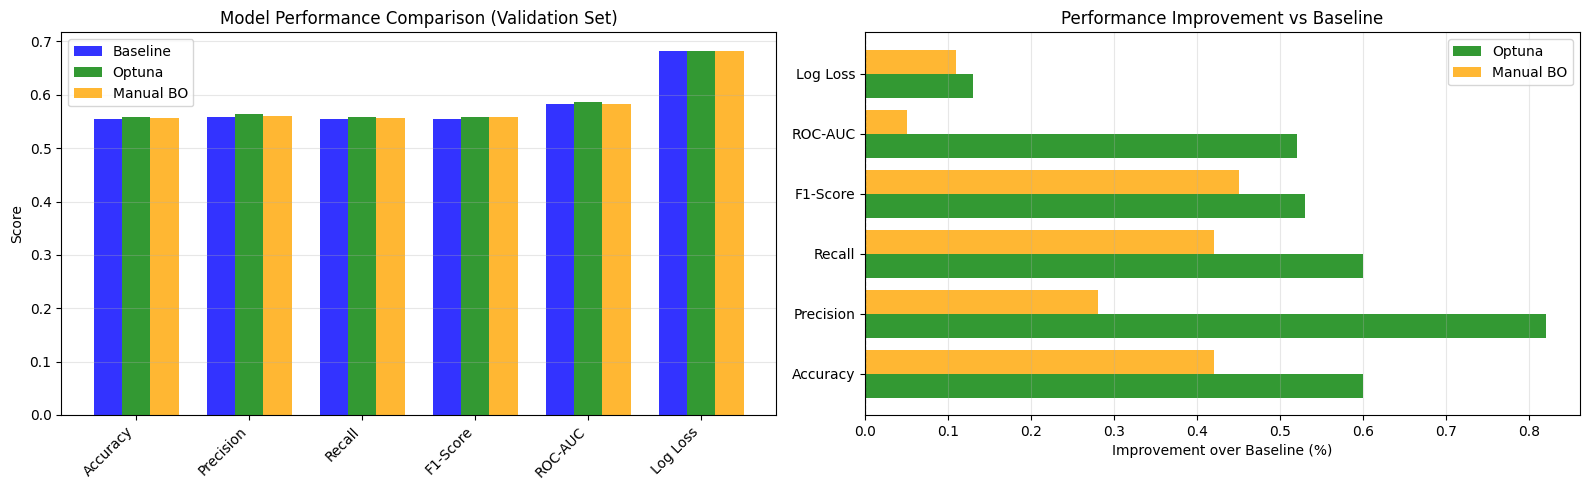

In [13]:
# Visualize comparison of all three models
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot comparison
metrics = comparison_df['Metric'].tolist()
x = np.arange(len(metrics))
width = 0.25

axes[0].bar(x - width, comparison_df['Baseline'], width, label='Baseline', alpha=0.8, color='blue')
axes[0].bar(x, comparison_df['Optuna'], width, label='Optuna', alpha=0.8, color='green')
axes[0].bar(x + width, comparison_df['Manual BO'], width, label='Manual BO', alpha=0.8, color='orange')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison (Validation Set)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Improvement percentage comparison
improvement_data = pd.DataFrame({
    'Metric': metrics,
    'Optuna': comparison_df['Optuna Improvement (%)'],
    'Manual BO': comparison_df['Manual BO Improvement (%)']
})

x_pos = np.arange(len(metrics))
axes[1].barh(x_pos - 0.2, improvement_data['Optuna'], 0.4, label='Optuna', alpha=0.8, color='green')
axes[1].barh(x_pos + 0.2, improvement_data['Manual BO'], 0.4, label='Manual BO', alpha=0.8, color='orange')
axes[1].set_yticks(x_pos)
axes[1].set_yticklabels(metrics)
axes[1].set_xlabel('Improvement over Baseline (%)')
axes[1].set_title('Performance Improvement vs Baseline')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## #3: Feature Importance Analysis

### #3.1: Calculate and Visualize Feature Importance
Analyze which features are most important for the tuned model's predictions.

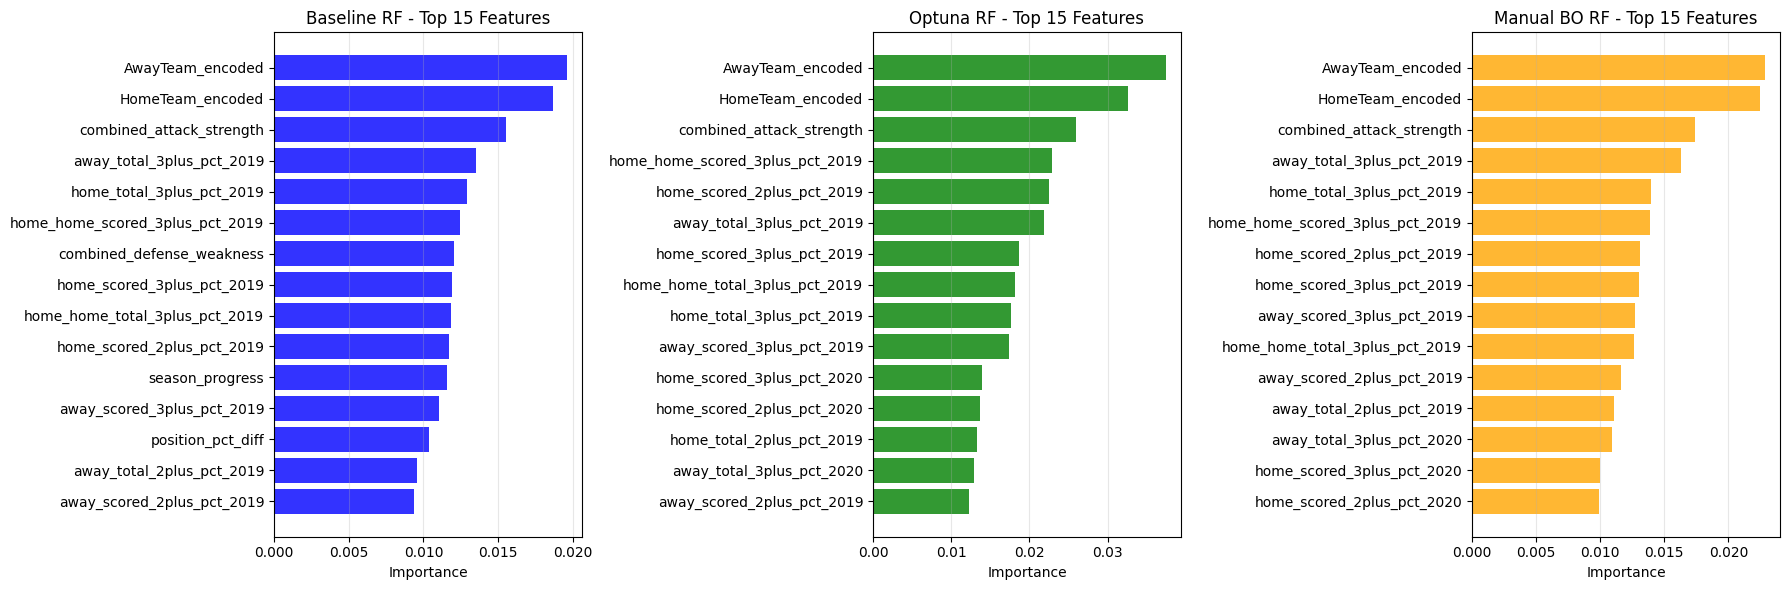


Top 10 Most Important Features (Optuna Model):
                        feature  importance
               AwayTeam_encoded    0.037514
               HomeTeam_encoded    0.032678
       combined_attack_strength    0.025987
home_home_scored_3plus_pct_2019    0.022923
     home_scored_2plus_pct_2019    0.022568
      away_total_3plus_pct_2019    0.021881
     home_scored_3plus_pct_2019    0.018622
 home_home_total_3plus_pct_2019    0.018195
      home_total_3plus_pct_2019    0.017700
     away_scored_3plus_pct_2019    0.017382


In [14]:
# Compare feature importances across all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

top_n = 15

# Baseline model
feature_importance_baseline = pd.DataFrame({
    'feature': X_train.columns,
    'importance': baseline_rf.feature_importances_
}).sort_values('importance', ascending=False)

axes[0].barh(range(top_n), feature_importance_baseline.head(top_n)['importance'], alpha=0.8, color='blue')
axes[0].set_yticks(range(top_n))
axes[0].set_yticklabels(feature_importance_baseline.head(top_n)['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title(f'Baseline RF - Top {top_n} Features')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Optuna model
feature_importance_optuna = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_optuna.feature_importances_
}).sort_values('importance', ascending=False)

axes[1].barh(range(top_n), feature_importance_optuna.head(top_n)['importance'], alpha=0.8, color='green')
axes[1].set_yticks(range(top_n))
axes[1].set_yticklabels(feature_importance_optuna.head(top_n)['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title(f'Optuna RF - Top {top_n} Features')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

# Manual BO model
feature_importance_manual = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_manual.feature_importances_
}).sort_values('importance', ascending=False)

axes[2].barh(range(top_n), feature_importance_manual.head(top_n)['importance'], alpha=0.8, color='orange')
axes[2].set_yticks(range(top_n))
axes[2].set_yticklabels(feature_importance_manual.head(top_n)['feature'])
axes[2].set_xlabel('Importance')
axes[2].set_title(f'Manual BO RF - Top {top_n} Features')
axes[2].invert_yaxis()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print top features for best model (let's say Optuna for now, but compare both)
print("\nTop 10 Most Important Features (Optuna Model):")
print(feature_importance_optuna.head(10).to_string(index=False))

### #3.2: Feature Importance Distribution Analysis
Analyze the distribution of feature importances and cumulative importance.

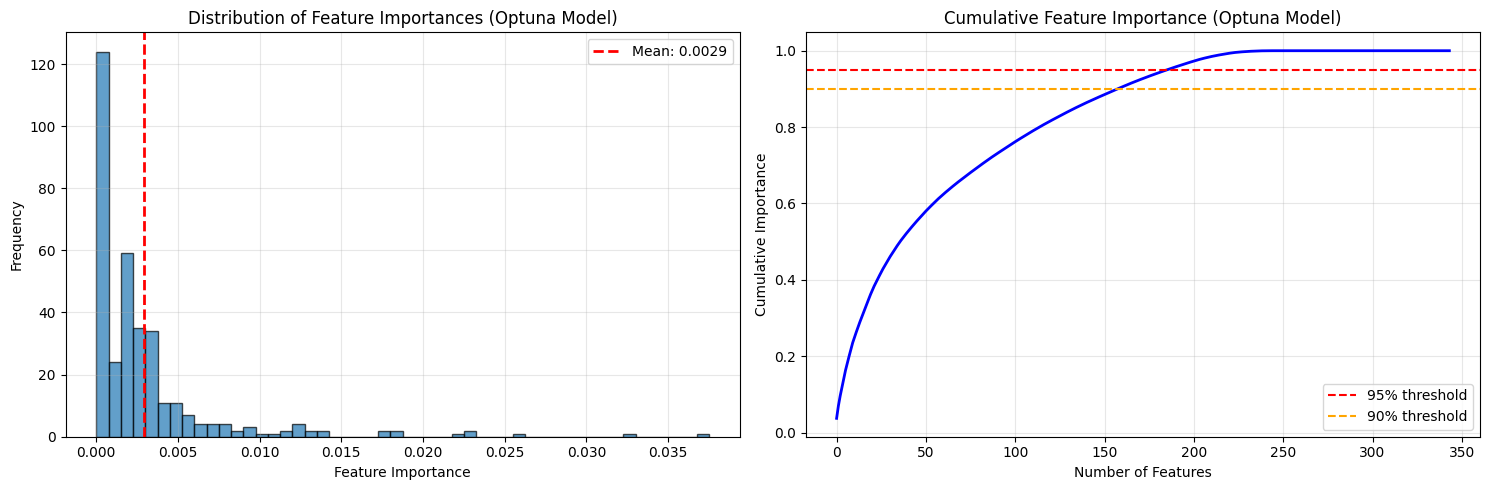


Feature Importance Summary (Optuna Model):
  Total features: 344
  Features capturing 90% importance: 159 (46.2%)
  Features capturing 95% importance: 186 (54.1%)


In [15]:
# Use Optuna model for detailed analysis (best performing)
feature_importance = feature_importance_optuna.copy()

# Calculate cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Importance distribution
ax1.hist(feature_importance['importance'], bins=50, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Feature Importance')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Feature Importances (Optuna Model)')
ax1.axvline(feature_importance['importance'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Mean: {feature_importance["importance"].mean():.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative importance
ax2.plot(range(len(feature_importance)), feature_importance['cumulative_importance'], 'b-', linewidth=2)
ax2.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
ax2.axhline(y=0.90, color='orange', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance')
ax2.set_title('Cumulative Feature Importance (Optuna Model)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Report how many features capture 90% and 95% of importance
n_features_90 = (feature_importance['cumulative_importance'] <= 0.90).sum() + 1
n_features_95 = (feature_importance['cumulative_importance'] <= 0.95).sum() + 1

print(f"\nFeature Importance Summary (Optuna Model):")
print(f"  Total features: {len(feature_importance)}")
print(f"  Features capturing 90% importance: {n_features_90} ({n_features_90/len(feature_importance)*100:.1f}%)")
print(f"  Features capturing 95% importance: {n_features_95} ({n_features_95/len(feature_importance)*100:.1f}%)")

### #3.3: Retrain Models on Combined Train+Validation Data

Before final test set evaluation, retrain all models on the combined training and validation data (2019-2024 seasons) to maximize the amount of historical data available for predictions on the 2024/2025 test set.

**Methodological Note**: While hyperparameters were optimized using training data (2019-2023) and validated on 2023/2024 data, the final models are retrained on the combined dataset to use all available historical data before predicting the unseen 2024/2025 season. The hyperparameter values chosen in Section #2 remain fixed here—we only expand the training data to include the validation season prior to the final test set evaluation.

In [16]:
# Combine training and validation data for final model training
print("=" * 70)
print("COMBINING TRAIN + VALIDATION DATA FOR FINAL MODELS")
print("=" * 70)

X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([pd.Series(y_train), pd.Series(y_val)], axis=0)

# Reset index
X_train_full.reset_index(drop=True, inplace=True)
y_train_full.reset_index(drop=True, inplace=True)

print(f"\nCombined Training Data:")
print(f"Features: {X_train_full.shape}")
print(f"Over 2.5 rate: {y_train_full.mean():.2%}")
print(f"Total samples: {len(y_train_full):,}")

# Cache tuned hyperparameters selected during validation-based search (Section #2)
optuna_best_params = study.best_params.copy()
manual_best_params = manual_bo_params.copy()

# Retrain baseline model on combined train+val data (baseline configuration stays unchanged)
baseline_rf_final = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("\n🔄 Retraining Baseline Random Forest on Train+Val...")
baseline_rf_final.fit(X_train_full, y_train_full)
print("✅ Baseline model retrained")

# Retrain Optuna model on combined train+val data with best hyperparameters from Section #2
rf_optuna_final = RandomForestClassifier(
    **optuna_best_params,
    random_state=42,
    n_jobs=-1
)

print("\n🔄 Retraining Optuna-Optimized Random Forest on Train+Val...")
rf_optuna_final.fit(X_train_full, y_train_full)
print("✅ Optuna model retrained with optimized hyperparameters")

# Retrain Manual BO model on combined train+val data with best hyperparameters from Section #2
rf_manual_final = RandomForestClassifier(
    **manual_best_params,
    random_state=42,
    n_jobs=-1
)

print("\n🔄 Retraining Manual BO Random Forest on Train+Val...")
rf_manual_final.fit(X_train_full, y_train_full)
print("✅ Manual BO model retrained with optimized hyperparameters")

print("\n" + "=" * 70)
print("ALL MODELS RETRAINED ON FULL TRAINING DATA (2019-2024)")
print("Ready for test set evaluation on 2024/2025 season")
print("=" * 70)

COMBINING TRAIN + VALIDATION DATA FOR FINAL MODELS

Combined Training Data:
Features: (35464, 344)
Over 2.5 rate: 49.85%
Total samples: 35,464

🔄 Retraining Baseline Random Forest on Train+Val...
✅ Baseline model retrained

🔄 Retraining Optuna-Optimized Random Forest on Train+Val...
✅ Optuna model retrained with optimized hyperparameters

🔄 Retraining Manual BO Random Forest on Train+Val...
✅ Manual BO model retrained with optimized hyperparameters

ALL MODELS RETRAINED ON FULL TRAINING DATA (2019-2024)
Ready for test set evaluation on 2024/2025 season


## #4: Final Evaluation on Test Set

### #4.1: Evaluate All Models on Test Set
Test all three models (Baseline, Optuna, Manual BO) on the held-out test set to get final performance metrics.

In [17]:
# Evaluate all models on test set (using models retrained on train+val)
print("Evaluating all models on test set...")
baseline_test_results = evaluate_model(baseline_rf_final, X_test, y_test, "Baseline - Test Set")
optuna_test_results = evaluate_model(rf_optuna_final, X_test, y_test, "Optuna Optimized - Test Set")
manual_test_results = evaluate_model(rf_manual_final, X_test, y_test, "Manual  BO Optimized - Test Set")

Evaluating all models on test set...

Performance Metrics - Baseline - Test Set
Accuracy:  0.5386
Precision: 0.5399
Recall:    0.5386
F1-Score:  0.5288
ROC-AUC:   0.5642
Log Loss:  0.6896

Confusion Matrix:
[[1380 2135]
 [1154 2460]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.54      0.39      0.46      3515
    Over 2.5       0.54      0.68      0.60      3614

    accuracy                           0.54      7129
   macro avg       0.54      0.54      0.53      7129
weighted avg       0.54      0.54      0.53      7129


Performance Metrics - Optuna Optimized - Test Set
Accuracy:  0.5430
Precision: 0.5438
Recall:    0.5430
F1-Score:  0.5364
ROC-AUC:   0.5704
Log Loss:  0.6862

Confusion Matrix:
[[1484 2031]
 [1227 2387]]

Classification Report:
              precision    recall  f1-score   support

   Under 2.5       0.55      0.42      0.48      3515
    Over 2.5       0.54      0.66      0.59      3614

    accuracy          

### #4.2: Compare All Models on Test Set
Compare baseline and both optimized models' performance on the test set with comprehensive metrics.

In [18]:
# Create comprehensive test set comparison
test_comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Log Loss'],
    'Baseline': [
        baseline_test_results['accuracy'],
        baseline_test_results['precision'],
        baseline_test_results['recall'],
        baseline_test_results['f1'],
        baseline_test_results['roc_auc'],
        baseline_test_results['log_loss']
    ],
    'Optuna': [
        optuna_test_results['accuracy'],
        optuna_test_results['precision'],
        optuna_test_results['recall'],
        optuna_test_results['f1'],
        optuna_test_results['roc_auc'],
        optuna_test_results['log_loss']
    ],
    'Manual BO': [
        manual_test_results['accuracy'],
        manual_test_results['precision'],
        manual_test_results['recall'],
        manual_test_results['f1'],
        manual_test_results['roc_auc'],
        manual_test_results['log_loss']
    ]
})

# Calculate improvement percentages
test_comparison_df['Optuna Improvement (%)'] = ((test_comparison_df['Optuna'] - test_comparison_df['Baseline']) / test_comparison_df['Baseline'] * 100).round(2)
test_comparison_df['Manual BO Improvement (%)'] = ((test_comparison_df['Manual BO'] - test_comparison_df['Baseline']) / test_comparison_df['Baseline'] * 100).round(2)

# For Log Loss, invert the improvement calculation (reduction is improvement)
log_loss_idx = test_comparison_df['Metric'] == 'Log Loss'
test_comparison_df.loc[log_loss_idx, 'Optuna Improvement (%)'] = (
    ((test_comparison_df.loc[log_loss_idx, 'Baseline'].values - test_comparison_df.loc[log_loss_idx, 'Optuna'].values) / 
     test_comparison_df.loc[log_loss_idx, 'Baseline'].values * 100).round(2)[0]
)
test_comparison_df.loc[log_loss_idx, 'Manual BO Improvement (%)'] = (
    ((test_comparison_df.loc[log_loss_idx, 'Baseline'].values - test_comparison_df.loc[log_loss_idx, 'Manual BO'].values) / 
     test_comparison_df.loc[log_loss_idx, 'Baseline'].values * 100).round(2)[0]
)

print("\n" + "="*80)
print("TEST SET COMPARISON: Baseline vs Optuna vs Manual BO")
print("="*80)
print(test_comparison_df.to_string(index=False))
print("="*80)


TEST SET COMPARISON: Baseline vs Optuna vs Manual BO
   Metric  Baseline   Optuna  Manual BO  Optuna Improvement (%)  Manual BO Improvement (%)
 Accuracy  0.538645 0.542993   0.542292                    0.81                       0.68
Precision  0.539915 0.543795   0.543792                    0.72                       0.72
   Recall  0.538645 0.542993   0.542292                    0.81                       0.68
 F1-Score  0.528801 0.536359   0.532834                    1.43                       0.76
  ROC-AUC  0.564238 0.570408   0.569821                    1.09                       0.99
 Log Loss  0.689636 0.686172   0.687096                    0.50                       0.37


### #4.3: Performance Summary Across All Sets
Compare model performance across validation and test sets.


PERFORMANCE SUMMARY - VALIDATION AND TEST SETS
   Dataset     Model  Accuracy  F1-Score  ROC-AUC  Log Loss
Validation  Baseline  0.554850  0.555065 0.582549  0.682884
      Test  Baseline  0.538645  0.528801 0.564238  0.689636
Validation    Optuna  0.558162  0.557982 0.585595  0.682023
      Test    Optuna  0.542993  0.536359 0.570408  0.686172
Validation Manual BO  0.557196  0.557562 0.582846  0.682132
      Test Manual BO  0.542292  0.532834 0.569821  0.687096


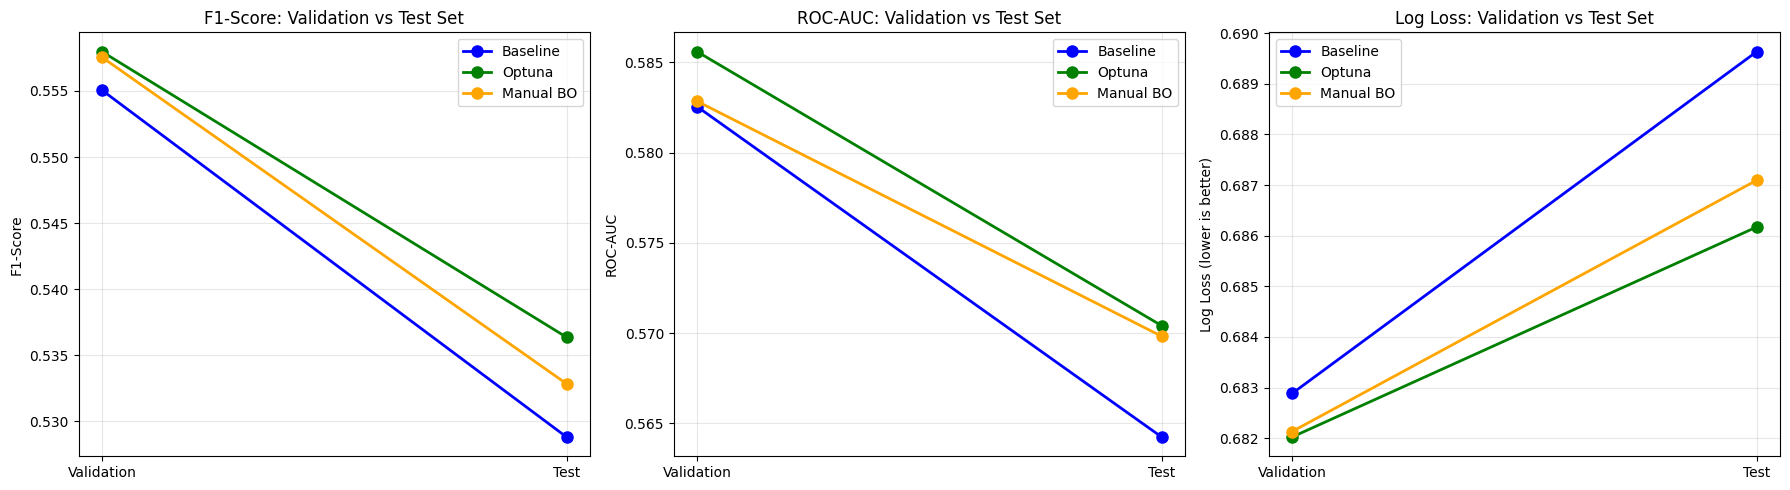

In [19]:
# Create comprehensive summary across all datasets
summary_data = {
    'Dataset': ['Validation', 'Test'] * 3,
    'Model': ['Baseline'] * 2 + ['Optuna'] * 2 + ['Manual BO'] * 2,
    'Accuracy': [
        baseline_val_results['accuracy'],
        baseline_test_results['accuracy'],
        optuna_val_results['accuracy'],
        optuna_test_results['accuracy'],
        manual_val_results['accuracy'],
        manual_test_results['accuracy']
    ],
    'F1-Score': [
        baseline_val_results['f1'],
        baseline_test_results['f1'],
        optuna_val_results['f1'],
        optuna_test_results['f1'],
        manual_val_results['f1'],
        manual_test_results['f1']
    ],
    'ROC-AUC': [
        baseline_val_results['roc_auc'],
        baseline_test_results['roc_auc'],
        optuna_val_results['roc_auc'],
        optuna_test_results['roc_auc'],
        manual_val_results['roc_auc'],
        manual_test_results['roc_auc']
    ],
    'Log Loss': [
        baseline_val_results['log_loss'],
        baseline_test_results['log_loss'],
        optuna_val_results['log_loss'],
        optuna_test_results['log_loss'],
        manual_val_results['log_loss'],
        manual_test_results['log_loss']
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("PERFORMANCE SUMMARY - VALIDATION AND TEST SETS")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# Plot performance across datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# F1-Score across datasets
datasets = ['Validation', 'Test']
baseline_f1 = [baseline_val_results['f1'], baseline_test_results['f1']]
optuna_f1 = [optuna_val_results['f1'], optuna_test_results['f1']]
manual_f1 = [manual_val_results['f1'], manual_test_results['f1']]

axes[0].plot(datasets, baseline_f1, 'o-', linewidth=2, markersize=8, label='Baseline', color='blue')
axes[0].plot(datasets, optuna_f1, 'o-', linewidth=2, markersize=8, label='Optuna', color='green')
axes[0].plot(datasets, manual_f1, 'o-', linewidth=2, markersize=8, label='Manual BO', color='orange')
axes[0].set_ylabel('F1-Score')
axes[0].set_title('F1-Score: Validation vs Test Set')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ROC-AUC across datasets
baseline_auc = [baseline_val_results['roc_auc'], baseline_test_results['roc_auc']]
optuna_auc = [optuna_val_results['roc_auc'], optuna_test_results['roc_auc']]
manual_auc = [manual_val_results['roc_auc'], manual_test_results['roc_auc']]

axes[1].plot(datasets, baseline_auc, 'o-', linewidth=2, markersize=8, label='Baseline', color='blue')
axes[1].plot(datasets, optuna_auc, 'o-', linewidth=2, markersize=8, label='Optuna', color='green')
axes[1].plot(datasets, manual_auc, 'o-', linewidth=2, markersize=8, label='Manual BO', color='orange')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_title('ROC-AUC: Validation vs Test Set')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Log Loss across datasets (lower is better)
baseline_logloss = [baseline_val_results['log_loss'], baseline_test_results['log_loss']]
optuna_logloss = [optuna_val_results['log_loss'], optuna_test_results['log_loss']]
manual_logloss = [manual_val_results['log_loss'], manual_test_results['log_loss']]

axes[2].plot(datasets, baseline_logloss, 'o-', linewidth=2, markersize=8, label='Baseline', color='blue')
axes[2].plot(datasets, optuna_logloss, 'o-', linewidth=2, markersize=8, label='Optuna', color='green')
axes[2].plot(datasets, manual_logloss, 'o-', linewidth=2, markersize=8, label='Manual BO', color='orange')
axes[2].set_ylabel('Log Loss (lower is better)')
axes[2].set_title('Log Loss: Validation vs Test Set')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### #4.4: Save Best Models and Results
Save the optimized models and best parameters for future use.

In [20]:
# Determine best model based on test set Log Loss (lower is better)
import joblib

best_model_name = 'Optuna' if optuna_test_results['log_loss'] <= manual_test_results['log_loss'] else 'Manual BO'
best_model = rf_optuna_final if best_model_name == 'Optuna' else rf_manual_final
best_params_final = study.best_params if best_model_name == 'Optuna' else manual_bo_params
best_test_logloss = optuna_test_results['log_loss'] if best_model_name == 'Optuna' else manual_test_results['log_loss']

print(f"\nBest Model: {best_model_name} (Test Log Loss: {best_test_logloss:.6f})")

# Save all results in a single comprehensive file
results_save_path = './outputs/models/baseline_rf_results.pkl'
results_dict = {
    # Evaluation results
    'baseline_val': baseline_val_results,
    'baseline_test': baseline_test_results,
    'optuna_val': optuna_val_results,
    'optuna_test': optuna_test_results,
    'manual_val': manual_val_results,
    'manual_test': manual_test_results,
    
    # Models (final versions trained on train+val)
    'baseline_model': baseline_rf_final,
    'optuna_model': rf_optuna_final,
    'manual_bo_model': rf_manual_final,
    'best_model': best_model,
    'best_model_name': best_model_name,
    
    # Parameters
    'optuna_params': study.best_params,
    'manual_bo_params': manual_bo_params,
    'best_params': best_params_final,
    
    # Analysis
    'feature_importance': feature_importance,
    'optuna_study': study
}
joblib.dump(results_dict, results_save_path)
print(f"\nAll models, parameters, and results saved to: {results_save_path}")
print(f"   - Baseline, Optuna, and Manual BO models (trained on 2019-2024)")
print(f"   - All hyperparameters and optimization history")
print(f"   - Feature importance analysis")
print(f"   - Validation and test set results")

print("\n" + "="*80)
print(f"BEST MODEL CONFIGURATION ({best_model_name})")
print("="*80)
for key, value in best_params_final.items():
    print(f"  {key}: {value}")
print("="*80)


Best Model: Optuna (Test Log Loss: 0.686172)

All models, parameters, and results saved to: ./outputs/models/baseline_rf_results.pkl
   - Baseline, Optuna, and Manual BO models (trained on 2019-2024)
   - All hyperparameters and optimization history
   - Feature importance analysis
   - Validation and test set results

BEST MODEL CONFIGURATION (Optuna)
  n_estimators: 235
  max_depth: 7
  min_samples_split: 16
  min_samples_leaf: 5
  max_features: sqrt
  bootstrap: False
